In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
year1 = 2022
year2 = 2023
complaint_type = 'restaurant'
typeagency = 'FoodDOHMH'
reported_label = 'reported'
covar_path = '/share/garg/311_data/sb2377/tract_demographics.csv'
base_data_path = '/share/garg/311_data/sb2377/two_year_base_tract.csv'
year1_path = '/share/garg/311_data/sb2377/processed_{}_{}.csv'.format(complaint_type, year1)
year2_path = '/share/garg/311_data/sb2377/processed_{}_{}.csv'.format(complaint_type, year2)
save_path = '/share/garg/311_data/sb2377/processed_{}_two_year.h5'.format(complaint_type)

In [3]:
covariates_arr = pd.read_csv(covar_path)
base_df = pd.read_csv(base_data_path)
df_year1 = pd.read_csv(year1_path)
df_year2 = pd.read_csv(year2_path)

In [4]:
rename_map = {'SegmentID': 'finegrained_id',
              'inspection_week': 'rating_week',
              'ManualRati': 'score',
              'normalized_ManualRati': 'normalized_score'
             }
df_year2 = df_year2.rename(columns=rename_map)
df_year2['report_week_of_year'] = df_year2['report_week']
df_year2['rating_week_of_year'] = df_year2['rating_week']

In [5]:
# get type idx
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
type_idx = type_df[type_df['typeagency'] == typeagency]['type_idxs'].iloc[0]

In [6]:
# merge reports for the last week of year 1 and the first week of year 2
# '*_week' = week number across both years
# '*_week_of_year' = week number within year
df_year2['report_week'] = df_year2['report_week_of_year'] + 52
df_year2['rating_week'] = df_year2['rating_week_of_year'] + 52

# combine reports for the last week of year 1 and the first week of year 2
df_year1['reported'] = df_year1['reported'].astype(int)
df_year2['reported'] = df_year2['reported'].astype(int)

# last week year 1
reported_year1 = df_year1[df_year1['report_week'] == 52][['finegrained_id', 'reported']]

# first week year 2
reported_year2 = df_year2[df_year2['report_week'] == 52][['finegrained_id', 'reported']]

# combine
merged_reports = pd.merge(reported_year1, reported_year2, on='finegrained_id', how='outer', suffixes=('_year1', '_year2'))
merged_reports.fillna(0, inplace=True)
merged_reports['reported_year1'] = merged_reports['reported_year1'].astype(bool)
merged_reports['reported_year2'] = merged_reports['reported_year2'].astype(bool)
merged_reports['reported'] = merged_reports['reported_year1'] | merged_reports['reported_year2']

# update last week year 1
df_year1_week = df_year1[df_year1['report_week'] == 52]
df_year1_week = df_year1_week.drop(columns=['reported'])
bbl_year1 = set(df_year1_week['finegrained_id'].unique())
merged_reports_year1 = merged_reports[merged_reports['finegrained_id'].isin(bbl_year1)][['finegrained_id', 'reported']]
df_year1_week = pd.merge(df_year1_week, merged_reports_year1, on='finegrained_id')
report_week = df_year1_week.iloc[0]['report_week_of_year']

# update first week year 2
df_year2_week = df_year2[df_year2['report_week'] == 52]
df_year2_week = df_year2_week.drop(columns=['reported'])
bbl_year2 = set(df_year2_week['finegrained_id'].unique())
bbl_year2_only = bbl_year2.difference(bbl_year1)
merged_reports_year2 = merged_reports[merged_reports['finegrained_id'].isin(bbl_year2)][['finegrained_id', 'reported']]
df_year2_week = pd.merge(df_year2_week, merged_reports_year2, on='finegrained_id')
df_year2_week = df_year2_week[df_year2_week['finegrained_id'].isin(bbl_year2_only)]
df_year2_week['report_week_of_year'] = report_week

# add to year 1
df_year1 = pd.concat([df_year1[df_year1['report_week'] != 52], df_year1_week], axis=0)

# add to year 2
df_year2 = pd.concat([df_year2[df_year2['report_week'] != 52], df_year2_week], axis=0)

# combine both years of data
df = pd.concat([df_year1, df_year2])

In [7]:
# for weeks without an inspection, set inspection fields to NAN
df.loc[df['report_week'] != df['rating_week'], 'score'] = np.nan
df.loc[df['report_week'] != df['rating_week'], 'rating_week'] = np.nan
df.loc[df['report_week'] != df['rating_week'], 'rating_week_of_year'] = np.nan

In [8]:
# create num finegrained entities x num weeks full T and r dataset
finegrained_entities_in_geoid = df.groupby('finegrained_id')['GEOID'].nunique()
valid_finegrained_entities = finegrained_entities_in_geoid[finegrained_entities_in_geoid == 1].index
df = df[df['finegrained_id'].isin(valid_finegrained_entities)]

dfs = []    
for i in sorted(df['report_week'].unique()):
    data = pd.DataFrame()
    data['finegrained_id'] = valid_finegrained_entities
    data['report_week'] = i
    dfs.append(data)
    
all_data = pd.concat(dfs)

# add in T labels
# set T = 1 for instances where there is a complaint
all_data = pd.merge(all_data, df[['finegrained_id', 'report_week', 'reported']].drop_duplicates(), on=['finegrained_id', 'report_week'], how='left')
all_data['reported'] = all_data['reported'].fillna(0)
all_data['finegrained_reported'] = all_data['reported']

# add in rating data
rated_df = df[df['score'].notna()]
all_data = pd.merge(all_data, rated_df[['finegrained_id', 'report_week', 'score', 'rating_week', 'rating_week_of_year']], on=['finegrained_id', 'report_week'], how='left')
all_data['real_rating_observed'] = 1

# add in report week
report_week_df = df[['report_week', 'report_week_of_year']].drop_duplicates()
all_data = pd.merge(all_data, report_week_df, on=['report_week'], how='left')

# assume constant rating until next inspection 
all_data.sort_values(by=['finegrained_id', 'report_week'], inplace=True)
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data['rating_week_of_year'] = all_data.groupby('finegrained_id')['rating_week_of_year'].ffill()
all_data = all_data[::-1]
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data['rating_week_of_year'] = all_data.groupby('finegrained_id')['rating_week_of_year'].ffill()
all_data = all_data[::-1]

# add in demographic data
all_data = pd.merge(all_data, df[['finegrained_id', 'GEOID']].drop_duplicates(), on=['finegrained_id'], how='left')
all_data['GEOID'] = all_data['GEOID'].astype(int)
all_data = pd.merge(all_data, covariates_arr, on=['GEOID'], how='left')

# add in meta data
all_data['typeagency'] = typeagency
all_data['type_idxs'] = type_idx

# get z-scored ratings
all_data['rating'] = all_data['score']
all_data['normalized_rating'] = (all_data['rating'] - all_data['rating'].mean()) / all_data['rating'].std()

In [9]:
assert(len(valid_finegrained_entities) * len(df['report_week'].unique()) == len(all_data))

In [10]:
len(all_data)

1680735

In [12]:
all_data.to_hdf(save_path, key='df', mode='w')

In [11]:
# evaluate mean rating with and without a report
mean_1 = all_data[(all_data[reported_label] == 1)]['rating'].mean()
error_1 = all_data[(all_data[reported_label] == 1)]['rating'].std() / len(all_data)
mean_0 = all_data[(all_data[reported_label] == 0)]['rating'].mean()
error_0 = all_data[(all_data[reported_label] == 0)]['rating'].std() / len(all_data)
print('Mean rating of tracts with a report = {}, without a report = {}'.format(mean_1, mean_0))
print('95% CIs rating of tracts with a report = [{}, {}], without a report = [{}, {}]'.format(mean_1 - 1.96 * error_1, mean_1 + 1.96 * error_1, mean_0 - 1.96 * error_0, mean_0 + 1.96 * error_0))

Mean rating of tracts with a report = 1.7870819912593352, without a report = 1.8116495522819305
95% CIs rating of tracts with a report = [1.7870813753631725, 1.787082607155498], without a report = [1.8116489815325039, 1.811650123031357]


Optimization terminated successfully.
         Current function value: 0.164128
         Iterations 8


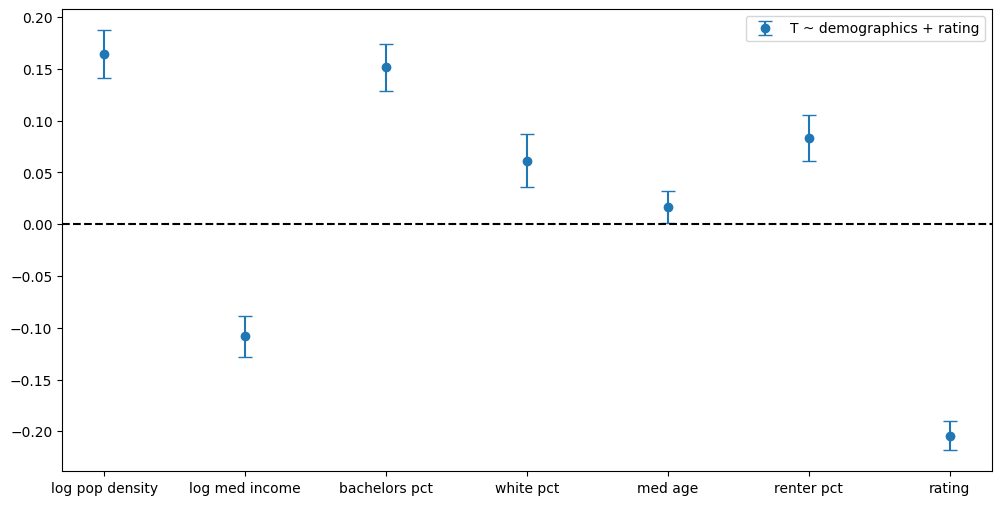

In [11]:
# run a regression of T ~ demographics + rating
covariates = ['log pop density',
              'log med income',
              'bachelors pct',
              'white pct',
              'med age',
              'renter pct'
             ]

normalized_covariates = ['normalized_log_population_density',
                         'normalized_log_income_median',
                         'normalized_education_bachelors_pct',
                         'normalized_race_white_nh_pct',
                         'normalized_age_median',
                         'normalized_households_renteroccupied_pct',
                         'normalized_rating'
                        ]

plt.figure(figsize=(12, 6))

y_label = reported_label
formula = y_label + ' ~ '
for c in normalized_covariates:
    formula += c + ' + '
formula = formula[:-3]

fit = sm.Logit.from_formula(formula, data = all_data).fit()
fit.summary()
coefficients = fit.params.to_numpy()[-7:]
conf_intervals = fit.conf_int().to_numpy()[-7:, :]
plt.errorbar(x=covariates + ['rating'], y=coefficients, 
             yerr=[coefficients - conf_intervals[:,0], conf_intervals[:,1] - coefficients], capsize=5, fmt='o', label='T ~ demographics + rating')

plt.axhline(0, color='black', linestyle='--')  # Horizontal dashed line at y=0
plt.legend()
plt.show()